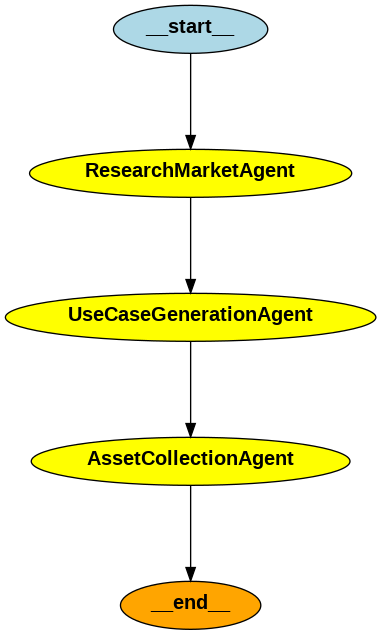

In [3]:
import operator
from typing import Annotated, Sequence, TypedDict,Union,List,Tuple
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
import functools
from langchain_core.messages import AIMessage
from langgraph.graph import END, StateGraph
from IPython.display import Image
#Import Agents:
from agents.research_market_agent import research_agent
from agents.usecase_agent import usecase_agent
from agents.resource_asset_agent import resource_assets_agent
#Import custom functions from utils.py
from utils import extract_use_cases
#Define the state of the graph
class MultiAgentState(TypedDict):
    user_query: str
    messages:Annotated[List,operator.add]
    results: List[dict]
    end:bool
#define agent Node 
def ResearchMarketAgent(state:MultiAgentState):
    input=state["user_query"]
    query=f"Conduct a deep market research for {input}"
    response=research_agent.invoke({"input":query})["output"]
    return {"messages":response}

def UseCaseGenerationAgent(state:MultiAgentState):
    messages=state["messages"]
    response=usecase_agent.invoke({"input":messages[-1]})["output"]
    usecases=extract_use_cases(response)
    return {"results":usecases}

def AssetCollectionAgent(state:MultiAgentState):
    messages=state["messages"]
    response=resource_assets_agent.invoke({"input":messages[-1]})["output"]
    return {"messages":response}

graph= StateGraph(MultiAgentState)
graph.add_node("ResearchMarketAgent", ResearchMarketAgent)
graph.add_node("UseCaseGenerationAgent", UseCaseGenerationAgent)
graph.add_node("AssetCollectionAgent",AssetCollectionAgent)

graph.set_entry_point("ResearchMarketAgent")
graph.add_edge("ResearchMarketAgent", "UseCaseGenerationAgent")
graph.add_edge("UseCaseGenerationAgent","AssetCollectionAgent")
graph.add_edge("AssetCollectionAgent", END)
agents = graph.compile()

Image(agents.get_graph().draw_png())